In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pymc as pm
from pymc.ode import DifferentialEquation

from itertools import product
import os.path as osp
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
import time
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display as print
from datetime import datetime
from scipy.integrate import odeint

import sunode
import pickle

In [2]:
class MyDataset(object):

    def __init__(self, dataset_path):

        self.dataset_path = dataset_path
        
        df = pd.read_csv(dataset_path)
        
        self.df = df
        self._setup()
    
    def _setup(self):
        
        df = self.df
        # 数据初步处理
        # 计算反应速率rate，初始速率固定设置为0
        for c_i, (col_name, col_sr) in enumerate(df.items()):
            if "error" in col_name or "time" in col_name or "rate" in col_name:
                continue
            rate_col_name = f"{col_name}_rate"
            rates = []
            pre_t = None
            pre_v = None
            for th, (index, value) in zip(df['time'], col_sr.items()):
                if int(index) == 0:
                    rates.append(0.0)
                    pre_t = th
                    pre_v = value
                    continue

                delta_t = th - pre_t
                delta_value = value - pre_v
                # print(col_name, index, pre_t, th, pre_v ,value)
                rates.append(delta_value / delta_t)
                pre_t = th
                pre_v = value
            df[rate_col_name] = rates

        # 准备输出值 Y
        self.cct_names = []
        for x in self.df.columns:
            if "time" in x or "error" in x or "rate" in x:
                continue
            self.cct_names.append(x)
        self.rates_names = [f"{x}_rate" for x in self.cct_names]
        self.error_names = [f"{x}-error" for x in self.cct_names]

        self.cct = self.df[self.cct_names].values
        self.rates = self.df[self.rates_names].values
        self.errors = self.df[self.error_names].values
    
    
    def set_as_sim_dataset(self, dcdt_fuc, t_eval, y0, args):
        
        y = odeint(dcdt_fuc, y0=y0, t=t_eval, args=args)
        
        # y.shape (size, 10)
        df_new = pd.DataFrame(columns=['time'] + self.cct_names)
        df_new['time'] = t_eval
        
        for c_name, col_val in zip(self.cct_names, np.transpose(y, [1,0])):
            df_new[c_name] = col_val
            df_new[f"{c_name}-error"] = 0.001
        
        self.df = df_new
        self._setup()
        
    
    def get_rates(self):
        return self.rates

    def get_df(self):
        return self.df

    def get_errors(self):
        return self.errors

    def get_cct(self):
        return self.cct

    def get_var_col_names(self):
        return self.cct_names, self.rates_names, self.error_names

    def get_weights(self):
        max_value = self.df[self.cct_names].describe().loc['max'].values.max()

        vars_max = self.df[self.cct_names].describe().loc['max']
        weights = (max_value / vars_max).values

        return np.array(weights)

    def get_vars_max(self):
        vars_max = self.df[self.cct_names].describe().loc['max'].values
        return vars_max


def get_format_time(f_s=None):
    haomiao = str(time.time()).split('.')[-1]
    if f_s is None:
        f_s = "%Y-%-m-%d %H:%M:%S."
        return datetime.now().strftime(f_s) + haomiao
    return datetime.now().strftime(f_s)

In [3]:
def get_dcdt_func(k_kinetics):
    k_kinetics = np.array(k_kinetics).astype(np.uint8)
    def _dcdt_func(t, c, p):
        r1 = p.k1 * c.xN2 if k_kinetics[0] == 1 else p.k1
        r2 = p.k2 * c.xNH3 if k_kinetics[1] == 1 else p.k2
        r3 = p.k3 * c.xNO2 if k_kinetics[2] == 1 else p.k3
        r4 = p.k4 * c.xNO3 if k_kinetics[3] == 1 else p.k4
        r5 = p.k5 * c.xNO2 if k_kinetics[4] == 1 else p.k5
        r6 = p.k6 * c.xNO2 * c.xNO3 if k_kinetics[5] == 1 else p.k6
        r7 = p.k7 * c.xNO3 if k_kinetics[6] == 1 else p.k7
        r8 = p.k8 * c.xNO3 if k_kinetics[7] == 1 else p.k8
        r9 = p.k9 * c.xNH3 if k_kinetics[8] == 1 else p.k9
        r10 = p.k10 * c.xNOrg if k_kinetics[9] == 1 else p.k10
        r11 = p.k11 * c.xNOrg if k_kinetics[10] == 1 else p.k11

        
        dc_xNH3 = 2 * r1 + r7 + r10 - r2 - r6 - r9
        dc_xNO3 = r3 - r7 - r4 - r8 + r11
        dc_xNO2 = r2 + r4 - r3 - r6 - 2 * r5
        dc_xNOrg = r8 + r9 - r10 - r11
        dc_xN2 = r5 + r6 - r1

        dc_ANH3 = (2 * r1 * (c.AN2 - c.ANH3) + (c.ANO3 - c.ANH3) * r7 + (c.ANOrg - c.ANH3) * r10) / c.xNH3
        dc_ANO3 = ((c.ANO2 - c.ANO3) * r2 + (c.ANOrg - c.ANO3) * r11) / c.xNO3
        dc_ANO2 = ((c.ANH3 - c.ANO2) * r2 + (c.ANO3 - c.ANO2) * r4) / c.xNO2
        dc_ANOrg = ((c.ANO3 - c.ANOrg) * r8 + (c.ANH3 - c.ANOrg) * r9) / c.xNOrg
        dc_AN2 = ((c.ANO2 - c.AN2) * r5 + (c.ANO2 * c.ANH3 - c.AN2) * r6) / c.xN2

        # dcdts = [dc_xNH3, dc_xNO3, dc_xNO2, dc_xNOrg, dc_xN2, dc_ANH3, dc_ANO3, dc_ANO2, dc_ANOrg, dc_AN2]
        
        dcdts =  {
            'xNH3': dc_xNH3,
            'xNO3': dc_xNO3,
            'xNO2': dc_xNO2,
            'xNOrg': dc_xNOrg,
            'xN2': dc_xN2,
            'ANH3': dc_ANH3,
            'ANO3': dc_ANO3,
            'ANO2': dc_ANO2,
            'ANOrg': dc_ANOrg,
            'AN2': dc_AN2,
        }
        return dcdts
    
    return _dcdt_func

def dcdt_func_for_odeint(c, t, ks, k_kinetics):

    # print(c, t, ks, k_kinetics)
    # print()
    c_xNH3, c_xNO3, c_xNO2, c_xNOrg, c_xN2, c_ANH3, c_ANO3, c_ANO2, c_ANOrg, c_AN2 = c
    
    r1 = ks[0] * c_xN2 if k_kinetics[0] == 1 else ks[0]
    r2 = ks[1] * c_xNH3 if k_kinetics[1] == 1 else ks[1]
    r3 = ks[2] * c_xNO2 if k_kinetics[2] == 1 else ks[2]
    r4 = ks[3] * c_xNO3 if k_kinetics[3] == 1 else ks[3]
    r5 = ks[4] * c_xNO2 if k_kinetics[4] == 1 else ks[4]
    r6 = ks[5] * c_xNO2 * c_xNO3 if k_kinetics[5] == 1 else ks[5]
    r7 = ks[6] * c_xNO3 if k_kinetics[6] == 1 else ks[6]
    r8 = ks[7] * c_xNO3 if k_kinetics[7] == 1 else ks[7]
    r9 = ks[8] * c_xNH3 if k_kinetics[8] == 1 else ks[8]
    r10 = ks[9] * c_xNOrg if k_kinetics[9] == 1 else ks[9]
    r11 = ks[10] * c_xNOrg if k_kinetics[10] == 1 else ks[10]
    
    

    dc_xNH3 = 2 * r1 + r7 + r10 - r2 - r6 - r9
    dc_xNO3 = r3 - r7 - r4 - r8 + r11
    dc_xNO2 = r2 + r4 - r3 - r6 - 2 * r5
    dc_xNOrg = r8 + r9 - r10 - r11
    dc_xN2 = r5 + r6 - r1
    dc_ANH3 = (2 * r1 * (c_AN2 - c_ANH3) + (c_ANO3 - c_ANH3) * r7 + (c_ANOrg - c_ANH3) * r10) / c_xNH3
    dc_ANO3 = ((c_ANO2 - c_ANO3) * r2 + (c_ANOrg - c_ANO3) * r11) / c_xNO3
    dc_ANO2 = ((c_ANH3 - c_ANO2) * r2 + (c_ANO3 - c_ANO2) * r4) / c_xNO2
    dc_ANOrg = ((c_ANO3 - c_ANOrg) * r8 + (c_ANH3 - c_ANOrg) * r9) / c_xNOrg
    dc_AN2 = ((c_ANO2 - c_AN2) * r5 + (c_ANO2 * c_ANH3 - c_AN2) * r6) / c_xN2

    dcdts = [dc_xNH3, dc_xNO3, dc_xNO2, dc_xNOrg, dc_xN2, dc_ANH3, dc_ANO3, dc_ANO2, dc_ANOrg, dc_AN2]

    return np.array(dcdts)

# simulator function
def competition_model(rng, t_eval, y0,  ks, k_kinetics, size=None):
    # print(y0)
    y = odeint(dcdt_func_for_odeint, y0=y0, t=t_eval, args=(ks, k_kinetics))
    return y

def get_predict_ks(idata):
    parames_summary = az.summary(idata, round_to=10)
    ks_names = [f"k{x+1}" for x in range(11)]

    predict_ks = []
    for k_name in ks_names:
        k_v = parames_summary["mean"][k_name]
        predict_ks.append(k_v)
    return np.array(predict_ks)
def get_predict_starts(cct_names, idata):
    parames_summary = az.summary(idata, round_to=10)
    s_names = [f"{x}_s" for x in cct_names]
    predict_s = []
    for s_name in s_names:
        k_v = parames_summary["mean"][s_name]
        predict_s.append(k_v)
    return np.array(predict_s)

In [4]:
def plot_dataset(dataset, dataset_pred=None):
    
    df = dataset.get_df()
    cct_names, rates_names, error_names = dataset.get_var_col_names()
    
    cols = 5
    rows = math.ceil(len(cct_names) / cols)

    fig, fig_axes = plt.subplots(ncols=cols, nrows=rows, figsize=(4.2 * cols, 4 * rows), dpi=100)
    if isinstance(fig_axes, np.ndarray):
        fig_axes = fig_axes.reshape(-1)
    else:
        fig_axes = [fig_axes]

    for i, axes in enumerate(fig_axes):
        if i >= len(cct_names):
            axes.axis('off')
            continue
        
        y_name = cct_names[i]
        Y = df[y_name].values
        axes.plot(df['time'].values, Y, '*', label=f"ob")
        axes.set_ylabel(f'cct_{y_name}')
        axes.set_xlabel(f'time(h)')

        # axes.plot(df['time'].values, df[rates_names[i]].values, '+', label=f"rate")
        
        if dataset_pred:
            _df_pred = dataset_pred.get_df()
            t_eval = _df_pred['time'].values
            axes.plot(t_eval, _df_pred[y_name].values, 'r', label=f"c(t)")
        
        
        # axes.plot(t_eval, dcdt_df[y_name].values,'g', label=f"c'(t)")

        axes.legend()
        # axes.set_title(f"{y_name}", fontsize=14)

    plt.tight_layout()
    plt.show()


In [5]:
def r2_loss(pred, y):
    r2_loss = 1 - np.square(pred - y).sum() / np.square(y - np.mean(y)).sum()
    return r2_loss

def get_model(dataset, t_eval, k_kinetics, k_sigma_priors=0.01, kf_type=0, distance="gaussian", epsilon=1):
    df = dataset.get_df()
    times = df['time'].values
    cct_names, rates_names, error_names = dataset.get_var_col_names()
    ccts = dataset.get_cct()
    
    mcmc_model = pm.Model()
    params_n = 11

    parames =[]
    c0 = []
    
    with mcmc_model:
        for ki in range(1, params_n + 1):
            if kf_type == 0:
                p_dense = pm.HalfNormal(f"k{ki}", sigma=k_sigma_priors)
                # _sigma = ks[ki-1] * np.pi **0.5 / 2 ** 0.5
                # p_dense = pm.HalfNormal(f"k{ki}", sigma=_sigma)
            else:
                p_dense = pm.Normal(f"k{ki}",mu=0, sigma=k_sigma_priors)
            parames.append(p_dense)
        
        # for c_name in cct_names:
        #     _maxx = df[c_name].values.max()
        #     _c0 = df[c_name].values[0]
        #     _sigma_c0 = _c0 * np.pi **0.5 / 2 ** 0.5

        #     # half_c0 = pm.HalfNormal(f"{c_name}_s", sigma=_maxx)
        #     half_c0 = pm.HalfNormal(f"{c_name}_s", sigma=_sigma_c0)
        #     # dira_c0 = pm.DiracDelta(f"{c_name}_s",c=_c0)
        #     c0.append(half_c0)
    c0 = df[cct_names].values[0]
    # print(c0)
    with mcmc_model:
        sim = pm.Simulator("sim", competition_model, params=(t_eval, c0, parames, k_kinetics),distance=distance, epsilon=epsilon, observed=ccts)
    
    return mcmc_model


def get_model2(dataset, t_eval, k_kinetics, k_sigma_priors=0.01, kf_type=0):

    df = dataset.get_df()
    times = df['time'].values
    
    errors = dataset.get_errors()
    rates = dataset.get_rates()
    cct_names, rates_names, error_names = dataset.get_var_col_names()
        
    # 定义参数优化模型
    mcmc_model = pm.Model()
    ## 参数个数
    params_n = 11
    parames ={}
    
    with mcmc_model:
        for ki in range(1, params_n + 1):
            if kf_type == 0:
                p_dense = pm.HalfNormal(f"k{ki}", sigma=k_sigma_priors)
            else:
                p_dense = pm.Normal(f"k{ki}",mu=0, sigma=k_sigma_priors)
            parames[f"k{ki}"] = (p_dense, ())
    
    parames['extra']=  np.zeros(1)
    
    c0 = {}
    with mcmc_model:
        for c_name in cct_names:
            _maxx = df[c_name].values.max()
            c0[f"{c_name}"] = (pm.HalfNormal(f"{c_name}_s", sigma=_maxx), ())
        

        y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
            y0=c0,
            params=parames,
            rhs=get_dcdt_func(k_kinetics),
            tvals=times,
            t0=times[0],
        )
        
        sd = pm.HalfNormal('sd')
        for c_name in cct_names:
            pm.Normal(f'{c_name}', mu=y_hat[f"{c_name}"], sigma=sd, observed=df[f"{c_name}"].values)
            pm.Deterministic(f'{c_name}_mu', y_hat[f"{c_name}"])

    return mcmc_model

In [6]:
# 假设都是一级动力学
k_kinetics = np.repeat(1, 11).astype(np.uint8) 
# ks = np.random.random(11)/100 # 先验k
ks = np.array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299, 0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432, 0.00177611])
#  =======================================================

# t_eval = np.linspace(0.5, 150, 8)
t_eval = np.array([0.5, 48, 96, 144])

db_csv_path = "dataset/data.csv"
idata_save_path = "odes-exp03-idata-4-number-success.dt"


dataset = MyDataset(db_csv_path)
df = dataset.get_df()
cct_names, rates_names, error_names = dataset.get_var_col_names()

c0 = df[cct_names].iloc[0].values
dataset.set_as_sim_dataset(dcdt_func_for_odeint, t_eval, c0, args=(ks, k_kinetics))
df = dataset.get_df()

In [7]:
df[cct_names]

,xNH3,xNO3,xNO2,xNOrg,xN2,ANH3,ANO3,ANO2,ANOrg,AN2
0,1.166667,2.398810,0.031100,62.285000,0.000071,7.948635,0.068579,0.072310,0.009857,0.008320
1,5.837087,5.539301,0.562177,52.633247,0.654953,1.032210,0.095807,0.616771,0.036312,1.427762
2,7.792909,7.098859,0.703303,45.482155,2.402246,0.478821,0.104952,0.301327,0.055499,0.602520
3,8.424422,7.693928,0.727245,39.954070,4.541027,0.288168,0.103458,0.194543,0.068299,0.357938


In [8]:
# epsilon = np.array([1,1,1,1,1,1,1,1,1,1])
from pymc.distributions.shape_utils import to_tuple
import pytensor.tensor as at

_data_max = df[cct_names].values.max()
epsilon = []
for c_name in cct_names:
    _max = df[c_name].values.max()
    epsilon.append(_data_max / _max)
epsilon = np.array(epsilon)

def distance_func(epsilon, obs_data, sim_data):
    # dis = -0.5 * ((obs_data - sim_data) / epsilon / 10) ** 2
    dis = -0.5 * ((obs_data - sim_data) * epsilon) ** 2
    return dis
# print(epsilon)

epsilon =   [1,   1,  100,   0.1, 10,   10, 10, 10, 1000, 10]

mcmc_model = get_model(dataset, t_eval, k_kinetics, distance=distance_func, epsilon=epsilon, k_sigma_priors=0.01, kf_type=0)

array([1.16666667e+00, 2.39880952e+00, 3.11000000e-02, 6.22850000e+01,
       7.11000000e-05, 7.94863498e+00, 6.85792330e-02, 7.23100000e-02,
       9.85666700e-03, 8.32000000e-03])

'2023-3-01 19:11:30.9796147'

'odes-exp03-idata-20-number-data.dt'

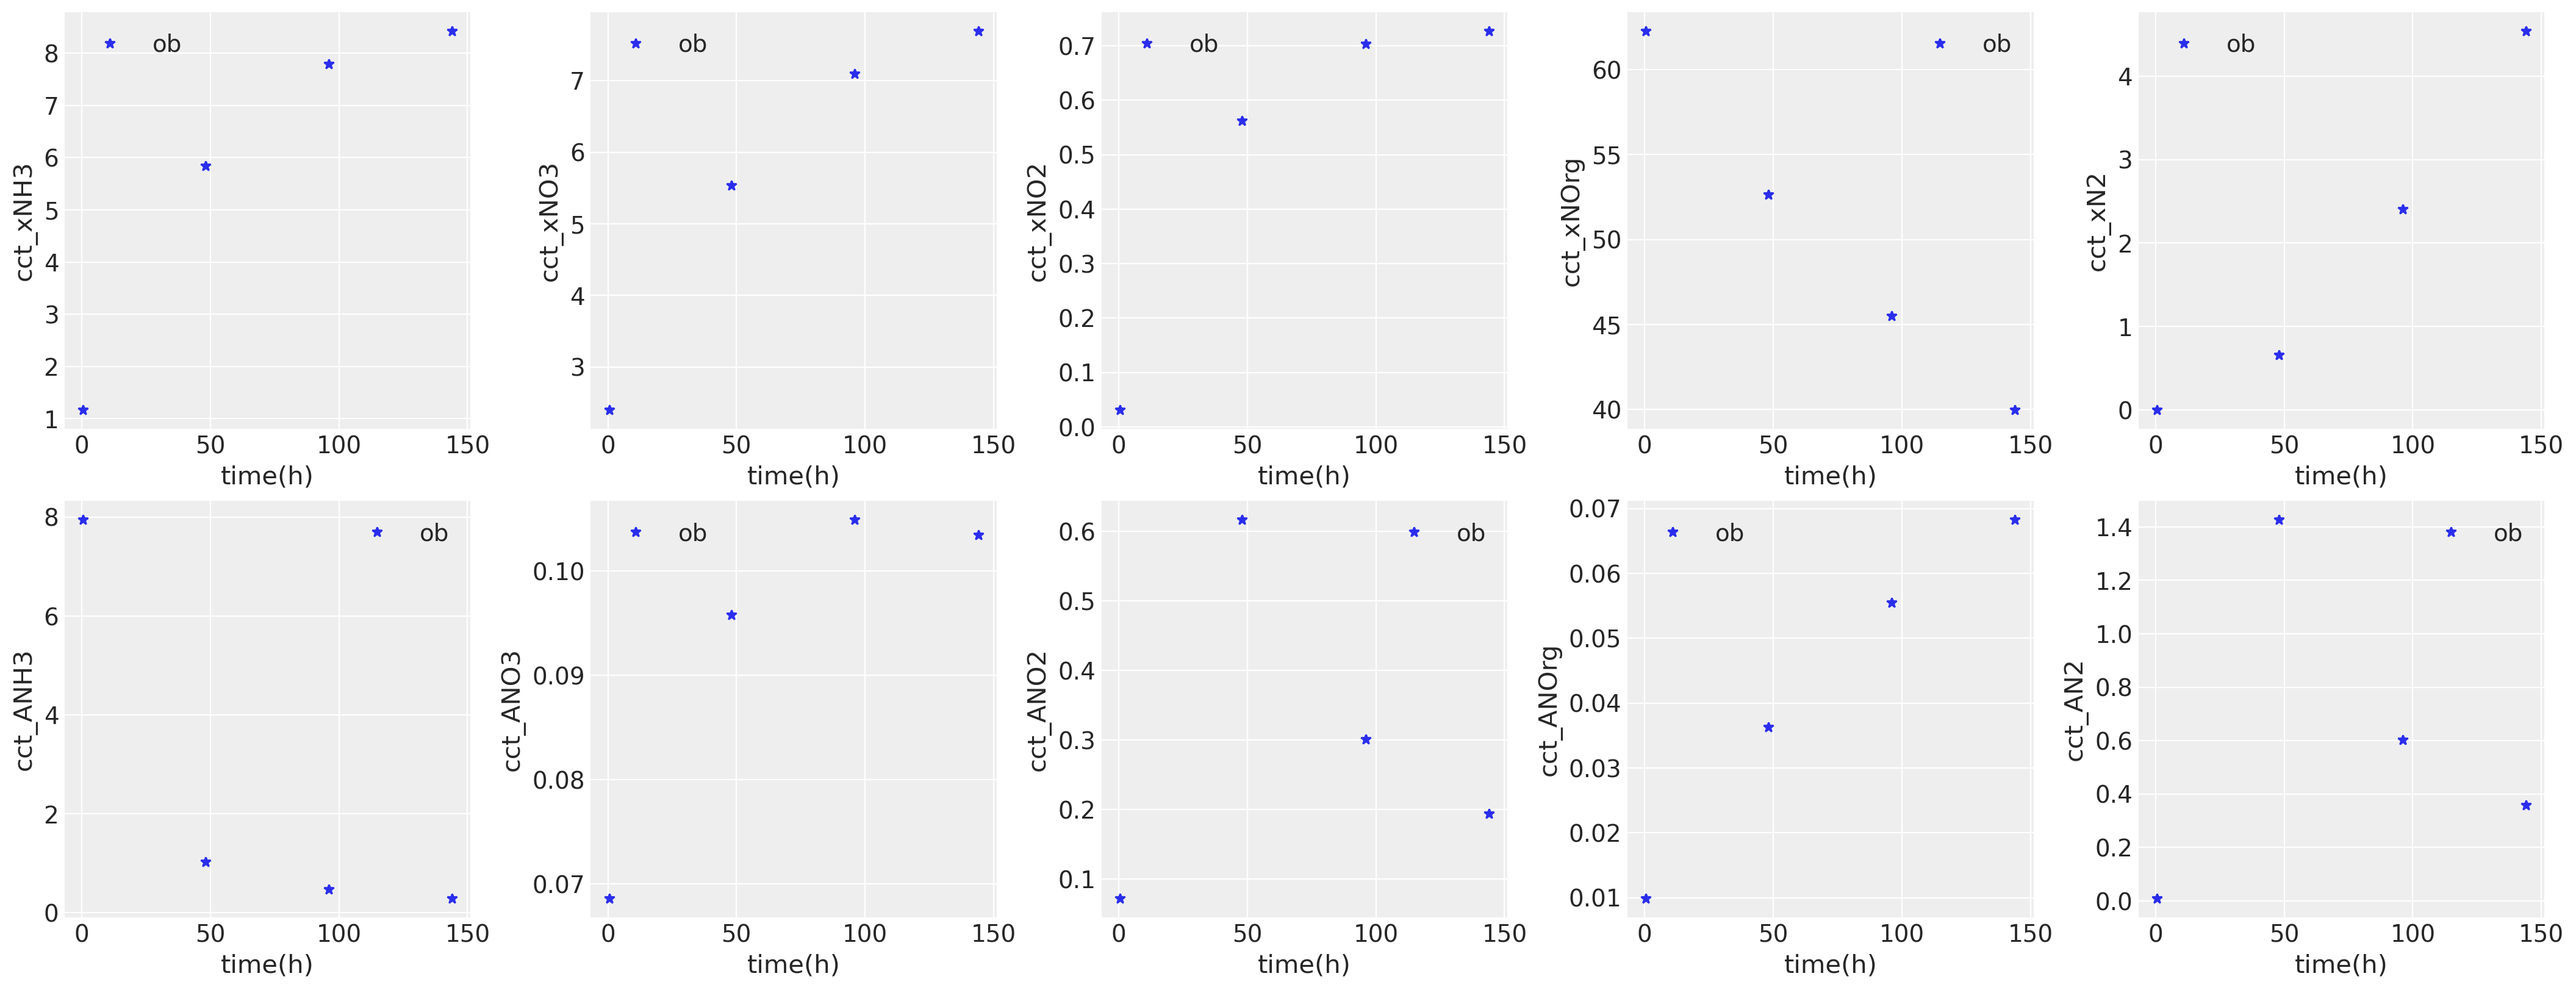

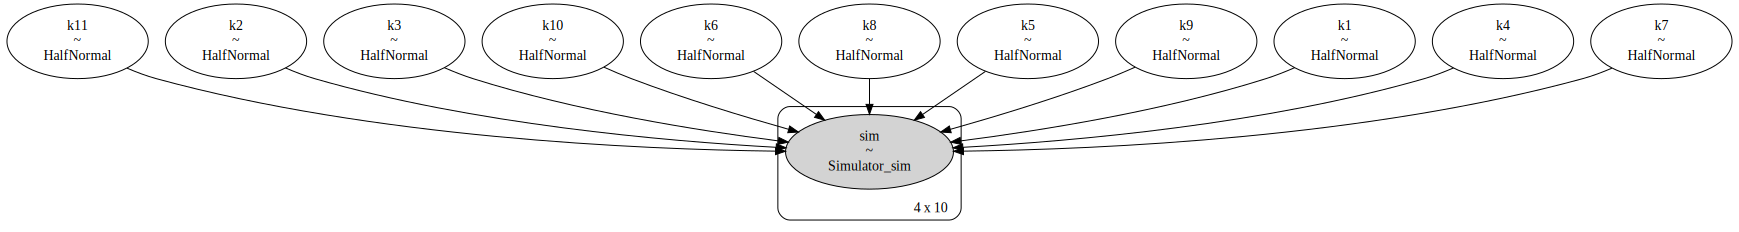

In [9]:
# print(get_format_time(),idata_save_path)
# print(ks, c0)
plot_dataset(dataset)
pm.model_to_graphviz(mcmc_model)

In [11]:
# idata_lv = pickle.load(open(idata_save_path, 'rb'))

idata_lv = pm.sample_smc(draws=2000, cores=4, model=mcmc_model)

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [18]:
idata_save_path = "odes-exp03-idata-4-number-success.dt"
pickle.dump(idata_lv,open(idata_save_path, 'wb'))
print(get_format_time())

'2023-3-01 20:16:00.2687137'

In [13]:
# az.plot_trace(idata_lv, kind="rank_vlines");
df[cct_names]

,xNH3,xNO3,xNO2,xNOrg,xN2,ANH3,ANO3,ANO2,ANOrg,AN2
0,1.166667,2.398810,0.031100,62.285000,0.000071,7.948635,0.068579,0.072310,0.009857,0.008320
1,5.837087,5.539301,0.562177,52.633247,0.654953,1.032210,0.095807,0.616771,0.036312,1.427762
2,7.792909,7.098859,0.703303,45.482155,2.402246,0.478821,0.104952,0.301327,0.055499,0.602520
3,8.424422,7.693928,0.727245,39.954070,4.541027,0.288168,0.103458,0.194543,0.068299,0.357938


In [14]:
print(az.summary(idata_lv, round_to=10))
print(ks)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k1,0.001536,0.000916,0.000217,0.003214,0.000014,0.000010,3927.166720,1265.625813,1.001931
k2,0.002985,0.000384,0.002271,0.003675,0.000008,0.000006,2600.988664,1982.177418,1.003242
k3,0.009135,0.005759,0.000581,0.019333,0.000131,0.000115,2186.694513,1459.575513,1.003656
k4,0.004783,0.000539,0.003767,0.005747,0.000008,0.000005,4763.172679,3588.336142,1.002120
k5,0.006215,0.003124,0.001583,0.012182,0.000059,0.000042,2581.828916,1373.115161,1.006884
k6,0.008243,0.000794,0.006762,0.009732,0.000011,0.000008,5233.613765,5920.953166,1.001610
k7,0.002279,0.001315,0.000293,0.004665,0.000022,0.000016,3742.652828,3390.350421,1.004901
k8,0.003661,0.002358,0.000334,0.007906,0.000057,0.000041,1014.716973,543.703119,1.012899
k9,0.004187,0.000176,0.003849,0.004502,0.000004,0.000003,2080.279178,2177.611505,1.004440
k10,0.002187,0.000197,0.001828,0.002557,0.000003,0.000002,3735.163297,3184.643683,1.002606


array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299,
       0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432,
       0.00177611])

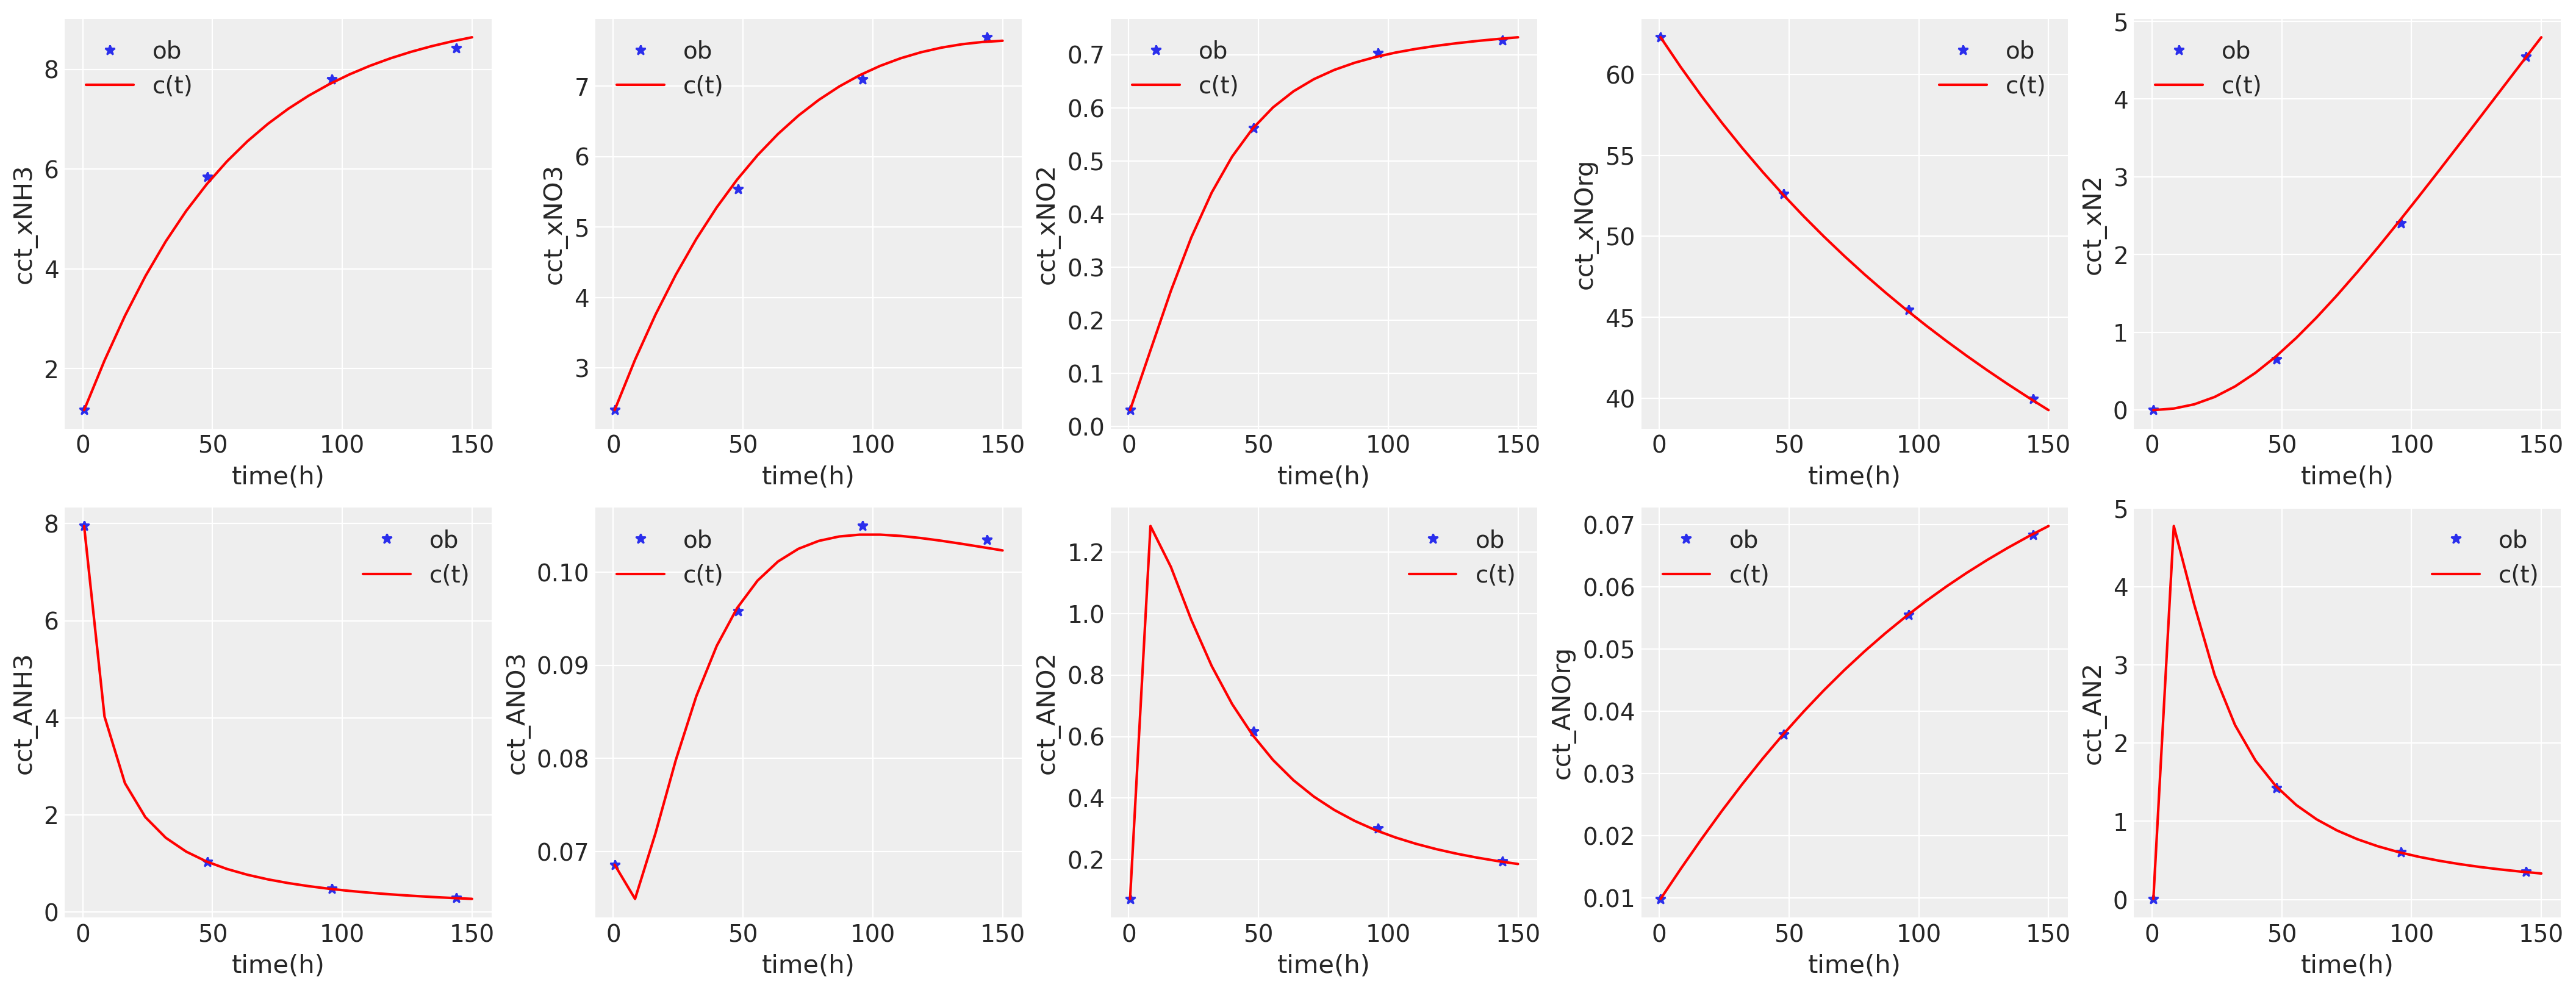

In [15]:
ks_predict = get_predict_ks(idata_lv)
k_kinetics = np.repeat(1, 11).astype(np.uint8)
t_eval_new = np.linspace(0.5 , 150, 20) # 注意 起始点的必须一致 个数不同的情况下 无法计算r2_loss


dataset_new = MyDataset(db_csv_path)
cct_names, rates_names, error_names = dataset_new.get_var_col_names()
gt_s = dataset_new.get_cct()[0]

dataset_new.set_as_sim_dataset(dcdt_func_for_odeint, t_eval, gt_s, args=(ks_predict, k_kinetics))

# print("r2_loss", r2_loss(dataset_new.get_cct(), dataset.get_cct()))
plot_dataset(dataset, dataset_new)


In [16]:
# az.plot_posterior(idata_lv);

In [ ]:
# 总结：
# 文件名：odes-exp03-idata-4-number-success.dt
# 运行时间：61分钟
# 其他的重要参数
#--------------------------------------------------------------------------
# k_kinetics = np.repeat(1, 11).astype(np.uint8) 
# ks = np.array([0.00071942, 0.00269696, 0.00498945, 0.00444931, 0.00571299, 0.00801272, 0.00131931, 0.00319959, 0.00415571, 0.00228432, 0.00177611])
# t_eval = np.array([0.5, 48, 96, 144])
# def distance_func(epsilon, obs_data, sim_data):
#     # dis = -0.5 * ((obs_data - sim_data) / epsilon / 10) ** 2
#     dis = -0.5 * ((obs_data - sim_data) * epsilon) ** 2
#     return dis
# epsilon =   [1,   1,  100,   0.1, 10,   10, 10, 10, 1000, 10]
